<a href="https://colab.research.google.com/github/hr1588/NLP/blob/main/new_dacon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패키지 및 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install transformers -qqq

In [3]:
import pandas as pd
train = pd.read_csv('train.csv')
train

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise
...,...,...,...,...,...
9984,TRAIN_9984,You or me?,Chandler,1038,neutral
9985,TRAIN_9985,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,1038,neutral
9986,TRAIN_9986,"You guys are messing with me, right?",Joey,1038,surprise
9987,TRAIN_9987,Yeah.,All,1038,neutral


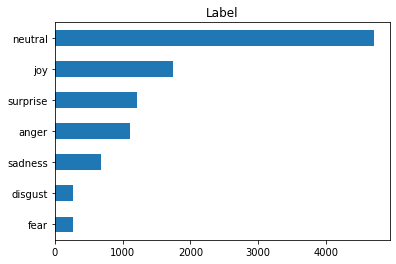

In [4]:
import matplotlib.pyplot as plt

train['Target'].value_counts(ascending = True).plot.barh()
plt.title('Label')
plt.show()

In [5]:
train['Target'].value_counts(ascending = True)

fear         268
disgust      271
sadness      683
anger       1109
surprise    1205
joy         1743
neutral     4710
Name: Target, dtype: int64

# label당 250개씩 데이터 분할

In [6]:
train[(train['Target'] == 'anger')].sample(100)

,ID,Utterance,Speaker,Dialogue_ID,Target
5603,TRAIN_5603,Don’t call us that!,Rachel,596,anger
6310,TRAIN_6310,And instead my parents got me this little plas...,Paul,660,anger
7902,TRAIN_7902,Would you tell her I let you win please?,Chandler,835,anger
4804,TRAIN_4804,"No? So you’re saying that if I called it, it w...",Rachel,512,anger
4896,TRAIN_4896,"Well, he made a move on me.",Phoebe,523,anger
...,...,...,...,...,...
334,TRAIN_0334,"It's your moral obligation, as a friend, as a ...",Ross,32,anger
3112,TRAIN_3112,"And you! I throw myself at you and you say no,...",Jill,328,anger
8322,TRAIN_8322,Wait a minute!,Rachel,874,anger
7854,TRAIN_7854,"No, hey, I get that, okay, I get that big time.",Ross,831,anger


In [7]:
import numpy as np
labels = list(np.unique(train['Target']))
labels

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

In [8]:
train_ad = []

for i in range(len(labels)):
    train_ad.append(train[(train['Target']==labels[i])].sample(250))

In [9]:
train_df = pd.concat(train_ad)
train_df['Target'].value_counts(ascending = True)

anger       250
disgust     250
fear        250
joy         250
neutral     250
sadness     250
surprise    250
Name: Target, dtype: int64

In [233]:
train_df.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
8117,TRAIN_8117,What?! What the hell?!,Phoebe,853,anger
3109,TRAIN_3109,Because I’m not going to spend one more day wi...,Jill,328,anger
467,TRAIN_0467,Come on apartment! Come on apartment! Oh! I k...,Rachel,46,anger
6549,TRAIN_6549,And-and that’s only ‘cause it’s right there wh...,Joey,679,anger
6725,TRAIN_6725,"No, no, no, don't! I've been waitin' for like,...",Joey,704,anger


In [10]:
train_df['label'] = train_df['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})
train_df = train_df.drop(columns = ['ID', 'Speaker', 'Dialogue_ID','Target'])

In [11]:
from sklearn.model_selection import train_test_split

t_data, v_data = train_test_split(train_df, test_size = 0.2, random_state = 42,
                                  stratify = train_df['label'])

In [12]:
print(t_data['label'].value_counts())
print(v_data['label'].value_counts())

5    200
3    200
6    200
2    200
1    200
0    200
4    200
Name: label, dtype: int64
4    50
5    50
0    50
1    50
2    50
3    50
6    50
Name: label, dtype: int64


In [13]:
!pip install datasets -qqq

In [14]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(t_data)
val_dataset = Dataset.from_pandas(v_data)

from datasets.dataset_dict import DatasetDict

raw_data = {
     'train':Dataset.from_dict({'Utterance':train_dataset['Utterance'], 'label' : train_dataset['label']}),
     'val':Dataset.from_dict({'Utterance':val_dataset['Utterance'], 'label' : val_dataset['label']})
     }

raw_data = DatasetDict(raw_data)
     
raw_data


DatasetDict({
    train: Dataset({
        features: ['Utterance', 'label'],
        num_rows: 1400
    })
    val: Dataset({
        features: ['Utterance', 'label'],
        num_rows: 350
    })
})

# 토큰화 및 모델 로드(distilbert)

In [72]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [73]:
def tokenize(batch):
    return tokenizer(batch["Utterance"], padding=True, truncation=True)

In [203]:
encoded_data = raw_data.map(tokenize, batched = True, batch_size = None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [204]:
encoded_data["train"].column_names

['Utterance', 'label', 'input_ids', 'attention_mask']

In [205]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(labels)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

In [22]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [20]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(encoded_data["train"]) // batch_size

training_args = TrainingArguments(output_dir='./result',
                                  num_train_epochs=20,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [208]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.928400,1.876493,0.274286,0.192880
2,1.822700,1.759850,0.377143,0.329806
3,1.704500,1.685940,0.377143,0.366377
4,1.572700,1.622977,0.411429,0.403698
5,1.466500,1.582283,0.414286,0.405276
6,1.328100,1.561157,0.425714,0.421543
7,1.233400,1.574756,0.420000,0.412316
8,1.121200,1.569636,0.408571,0.403537
9,1.029300,1.589998,0.411429,0.406736
10,0.945900,1.585154,0.425714,0.427049


TrainOutput(global_step=440, training_loss=0.9849104989658702, metrics={'train_runtime': 224.992, 'train_samples_per_second': 124.449, 'train_steps_per_second': 1.956, 'total_flos': 383982711672000.0, 'train_loss': 0.9849104989658702, 'epoch': 20.0})

## val로 계산

In [216]:
outputs = trainer.predict(encoded_data["val"])
y_pred = outputs.predictions.argmax(1)

array([4, 5, 2, 4, 0, 1, 5, 2, 0, 2, 3, 2, 1, 5, 1, 0, 2, 5, 5, 5, 5, 0,
       5, 2, 1, 6, 1, 6, 5, 2, 5, 5, 2, 0, 4, 4, 6, 0, 0, 2, 4, 1, 2, 2,
       0, 2, 2, 0, 1, 0, 4, 3, 5, 2, 4, 4, 6, 1, 5, 1, 6, 0, 0, 5, 0, 5,
       2, 4, 1, 4, 3, 3, 2, 2, 0, 4, 2, 5, 6, 4, 1, 2, 6, 1, 1, 5, 2, 3,
       1, 1, 2, 0, 5, 5, 2, 0, 3, 2, 2, 2, 5, 1, 6, 1, 5, 0, 1, 4, 2, 2,
       5, 6, 0, 0, 0, 5, 2, 0, 5, 4, 4, 1, 1, 3, 6, 5, 4, 4, 0, 2, 4, 0,
       3, 2, 6, 2, 0, 4, 1, 3, 6, 5, 2, 2, 2, 4, 2, 0, 4, 5, 4, 2, 0, 3,
       5, 2, 0, 0, 3, 0, 1, 4, 0, 6, 0, 5, 5, 5, 0, 6, 1, 0, 0, 1, 5, 0,
       4, 1, 2, 4, 3, 5, 5, 2, 4, 3, 0, 4, 4, 0, 6, 5, 6, 2, 2, 0, 0, 6,
       1, 0, 5, 1, 5, 0, 0, 6, 0, 6, 3, 5, 2, 3, 0, 5, 5, 3, 6, 0, 5, 2,
       4, 6, 6, 4, 4, 1, 2, 5, 6, 1, 0, 3, 2, 4, 0, 2, 2, 0, 0, 5, 4, 5,
       5, 0, 2, 4, 5, 3, 2, 4, 5, 1, 0, 2, 1, 1, 2, 4, 4, 3, 6, 4, 6, 4,
       2, 4, 4, 4, 6, 6, 2, 3, 5, 0, 0, 0, 6, 0, 6, 0, 6, 3, 1, 5, 0, 1,
       3, 1, 4, 0, 1, 2, 5, 5, 3, 3, 0, 2, 0, 3, 4,

In [219]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

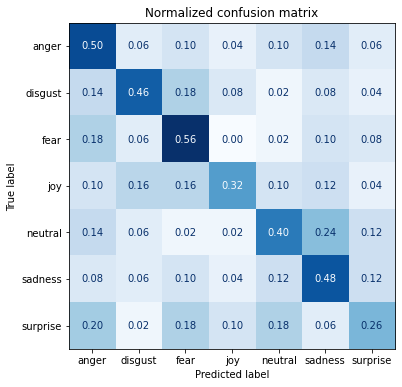

In [220]:
plot_confusion_matrix(y_pred, encoded_data["val"]['label'], labels)

# emoberta-large로 구현

In [15]:
from transformers import AutoTokenizer

model_name = "tae898/emoberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [16]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,<s>,<pad>,</s>,<unk>,<mask>
Special Token ID,0,1,2,3,50264


In [17]:
def tokenize(batch):
    return tokenizer(batch["Utterance"], padding=True, truncation=True)

In [18]:
encoded_data = raw_data.map(tokenize, batched = True, batch_size = None)
encoded_data['train'].column_names

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['Utterance', 'label', 'input_ids', 'attention_mask']

In [19]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(labels)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_name, num_labels=num_labels)
         .to(device))

In [23]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = data_collator
)

trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


OutOfMemoryError: ignored

In [ ]:
outputs = trainer.predict(encoded_data["val"])
y_pred = outputs.predictions.argmax(1)
plot_confusion_matrix(y_pred, encoded_data["val"]['label'], labels)